# BM 336546 - HW2: Type 1 Diabetes

## Theory Questions

**Q1** 

Even though the most known evaluation metric of a model is its *accuracy*, this metric is not always a good one. For example, lets say there is a very rare disease that affects only 1 person in 1,000,000 (namely, data is highly imbalanced). If we have a naive classifier that always says the sample patient is healthy, we could very well have 100% accuracy, but the model will not be useful at all. This is why accuracy is not always the best metric to use. There are many other evaluation metrics we use to score the *performance* of the model, which include (but are not limited to) sensitivity, specificity, PPV, NPV, F1 Score, and AUROC.

**Q2**

There are a couple of things to look at when choosing whether to use feature selection:

* Computational Complexity: The more features we have, the longer it takes to fit the models to the data. Therefore, if we want to reduce the computation time, we can reduce the number of features.

* Relevance: Sometimes, there are features which do not correlate at all with the data. For example, if we want to create a model that diagnoses T1D, a feature of 'Favorite Ice Cream Flavor' will probably not help us at all, and will only introduce noise into the classifier. In this example, it's not sure that 'Income' is a feature that will  highly correlate with Heart Attack, and therefore removing it might make the model better (although we should check with/without and see the test results). From a medical point of view, high BP, high Age and high BMI are considered as *risk factors* for Heart Attack, while Income deals wih socio-economic considerations (like education level). 

* Redundancy: Sometimes, two features that are basically derivatives of one another can be redundant, and one of them can be removed in order to reduce computation time. For instance we may expect a negative correlation between BMI and physical activity (low activity implies high BMI). 

* Overfitting: one rule of thumb is to have at least 10 examples for one feature, otherwise  it's likely that we'll overfit our data. Therefore a small dataset must be associated with a small number of features.  


For this question, we would use the model that includes all of the features, because the difference between 2 and 5 features isn't a lot, and the addition of 3 additional features would not hinder the computational ability.


**Q3**

It's safe to assume that many of the images of the biopsies have areas that are identical (meaning the pixels in that area are of the same gray level as the same ones in other images). This means that the data is probably not linearly separable. When using logistic regression or SVM with a linear kernel, we assume that the data is linearly seperable. Since this is not the case here, we would choose to use an SVM model that uses a non-linear kernel (such as RBF or poly). It is important to note that if we want the non-linear SVM to work, we should have a number of sample images that is greater than the number of features. If this is not the case, it is possible that the non-linear SVM won't work as well as it should.


**Q4**

When dealing with classification for linearly separable data, we may use SVM with a linear kernel or logistic regression. The difference is that logistic regression is a probabilistic model whereas SVM is geometrical: LR provides a "soft assignment", namely a probability. Then we can chose to play with the threshold in order to optimize Se/Sp according to our needs. This can't be done with SVM, which makes a decision for each occurence. 
Therefore, LR is less complex to implement and more flexible. We'll observe in the next part a big difference of calculation time between the two classifiers when cross-validating. 

The main hyperparameters for SVM are the capacity *C* and the kernel coefficients ( $\gamma$ if we choose RBF). For LR, the hyperparameter to tune is the regularization parameter $\lambda$. 

$C$ represents how much do we penalize missclassifications. Setting high values of $C$ will enforce the SVM to not make missclassifications, which leads to ovefitting. Conversely, $\lambda$ penalizes the big balues of the weights $w$: setting it very high leads to underfitting. Thus, we can write a 'conceptual' relationship between the capacity and the regularization: $C=1/ \lambda$. 




## Coding Assignment

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

warnings.filterwarnings('ignore')

### 1) Data Loading & Preprocessing

For pre-processing, we decided to go change all binary string classications (such as 'Yes' and 'No') to 1 and 0. In addition, we found nans in the data, and we filled them using an iterative imputer that takes into account the 2 nearest features (by correlation) when filling th nan with 1 or 0.

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df=pd.read_csv('HW2_data.csv')

#binary encoding of the data:
df.replace(['Yes', 'Positive', 'No', 'Negative', 'Male', 'Female'], [1, 1, 0, 0, 1, 0],inplace=True)

#Are they missing values? In which columns?
dicNa={}
for column in df.columns:
    dicNa[column]=df[column].isna().sum()

#iterative imputing:
df_train = df.iloc[0:500, :]
imp_most_freq = IterativeImputer(max_iter=100, n_nearest_features=2, random_state=42, initial_strategy='most_frequent')
imp_most_freq.fit(df_train)
df_new = imp_most_freq.transform(df).copy()
df_new = df_new.round()
df_new = pd.DataFrame(df_new)
df_new.columns = df.columns

### 2) Train-Test Split

Before performing a train-test split, we'll check if the data is imbalanced:

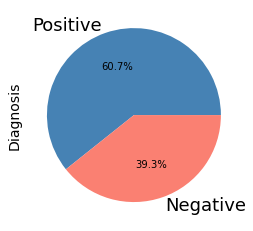

In [3]:
X = df_new.drop('Diagnosis', axis=1)
y = df_new.loc[:, 'Diagnosis']

y.value_counts().plot(kind="pie", labels=['Positive','Negative'], colors = ['steelblue', 'salmon'], autopct='%1.1f%%')
plt.show()

In [4]:
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, stratify=y)

### 3) Data Exploration

**a) Feature Distribution**

**i.** To begin with, we check if the distribution of the train set and the test set are similar. If they are not, then we will be over-fitting.

Let's start with the Age feature:

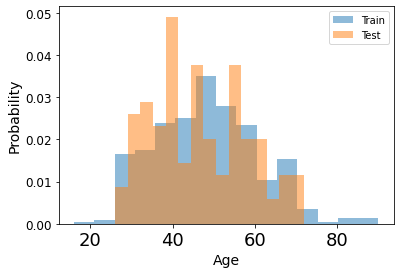

In [5]:
bins = 15
plt.figure()
plt.hist(X_train['Age'], bins, density=True, alpha=0.5, label='Train')
plt.hist(X_test['Age'], bins, density=True, alpha=0.5, label='Test')
plt.xlabel('Age')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.show()

The shape of the distribution is pretty much the same. Now, we'll create a table to check this for the categorical variables:

In [6]:
from HW2_Functions import compare_distrib

compare_distrib(X_train,X_test)

,Positive Feature,Train %,Test %,Delta %
0,Gender,62.6,68.1,5.5
1,Increased Urination,48.5,47.8,0.7
2,Increased Thirst,44,46,2
3,Sudden Weight Loss,40.5,40.7,0.2
4,Weakness,55.8,62.8,7.1
5,Increased Hunger,43.6,46,2.4
6,Genital Thrush,20.4,26.5,6.2
7,Visual Blurring,44.2,47.8,3.5
8,Itching,46.9,51.3,4.4
9,Irritability,22.6,27.4,4.9


As we can see, the distributions are similar, and we don't need to worry about over-fitting in this particular situation.

**ii**. If they were not similar, we would probably have to change the split percentage to a higher number (maybe 30% or 40%).


**b) Relation between features and label**

We'll visualize the relations between the binary variables and the label using *countplots*. 
For each category of each feature, we count the Positive and Negative (healthy) patients. We look for the features where a large difference between the counts exists. 


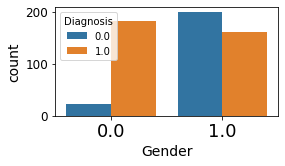

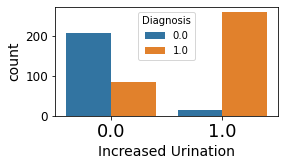

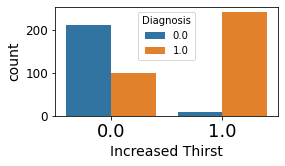

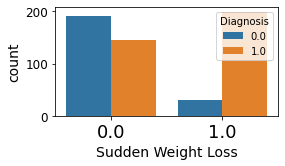

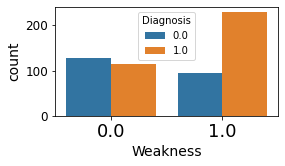

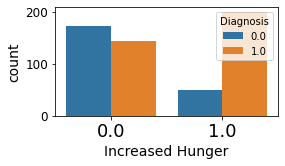

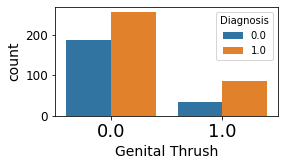

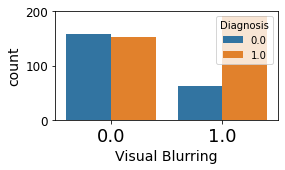

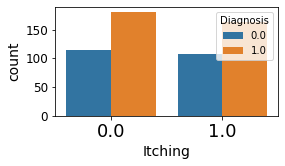

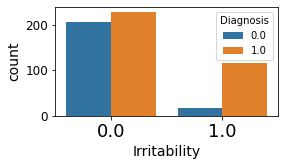

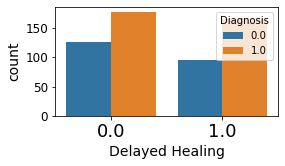

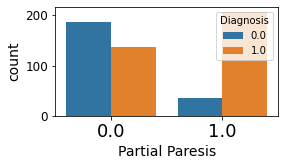

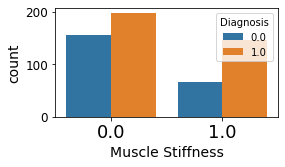

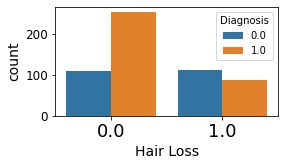

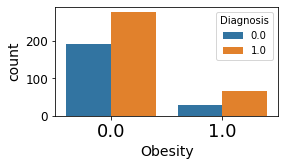

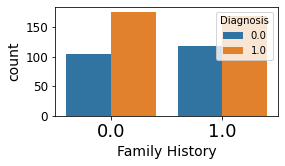

In [7]:
for column in X.columns[1:]:
    plt.figure(figsize = (4,2))
    sns.countplot(x=column,hue='Diagnosis',data=df_new)
    plt.show()

We see that a majority of women are positive, and a majority of patients with Increased Thirst/Urination. 

Now, we can also look at the relation between *Age* and *Diagnosis* using a boxplot:

<AxesSubplot:title={'center':'Age'}, xlabel='Diagnosis'>

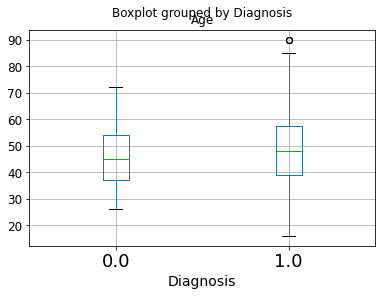

In [8]:
df_new.boxplot(column='Age',by='Diagnosis')

There are no clear difference between the two distributions. 


**c) Correlation Between features/ Between features and label**

Finally, we plot a correlation matrix in order to see the correlation between all of the categories:


<AxesSubplot:>

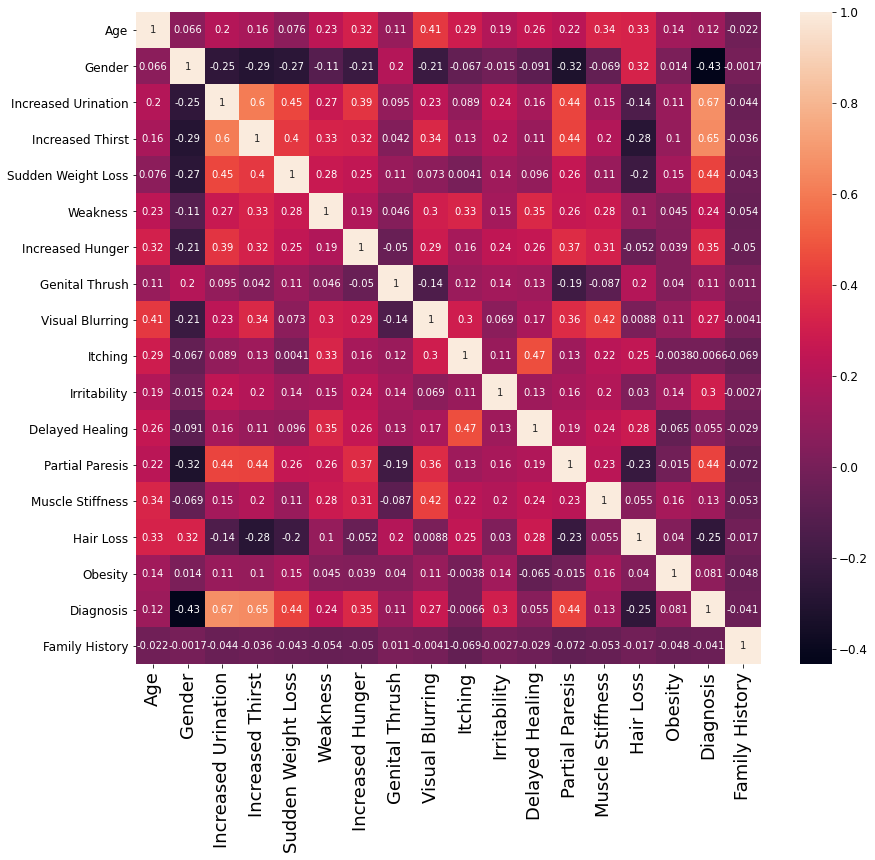

In [9]:
plt.figure(figsize = (14,12))
sns.heatmap(df_new.corr(), annot = True)

We can see that the features that are the more positively correlated with the *Diagnosis* are: *Increased Urination, Increased Thirst, Sudden Weight Loss, and Partial Paresis*. 

*Gender* (being male) is negatively correlated with the *Diagnosis*.

**d) Insights**

I. We think that 'Age' having no serious correlation with the diagnosis was surprising. Additionally, the correlation with the gender was also surprising. Indeed, age may be useful to discriminate between patients suffering from T1D (youth) or T2D (appears lately).

II. We think that Increased Thirst/Urination will be very important in our model, because they are the features that have the highest correlation with the diagnosis. 

### 4) Encoding

One-Hot vectoring is a representation of categorical values as binary vectors. The categorical values are represented as integers, and they are in turn each represented by a binary vector, where all values are zero except for the index of the correctly categorized sample, which is a one. In our case, we already have binary categorical data ('Yes'/'No', 'True/False', etc.). Therefore, it is our opinion that one-hot encoding our dataset would be redundant, because we would be creating 2 binary columns from 1 binary column, only increasing the complexity of the algorithm. In addition, from a bit of research, we found that one-hot encoding binary data could result in problems with Multi-Collinearity, Dimensionality, Overfitting, and Time/Memory Complexity. We decided that we would change the binary categorical values ('Yes'/'No', 'True/False', etc.) to ones and zeros, and scale the whole dataset to avoid problems with the 'Age' value, which is a continuous variable. All in all, we have 18 columns, 17 of which are binary and 1 of which is continuous (but scaled to the binary data).

### 5) Models

In [10]:
n_splits = 5
max_iter = 2000
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)


#### 5.1) Linear Models

**a) Logistic Regression**

In [11]:
from sklearn.linear_model import LogisticRegression

#Tuning our Hyperparameter lambda and the regularization scheme:
solver = 'liblinear' #supports both L1 and L2

def LR(X_train,Y_train):
    log_reg = LogisticRegression(random_state=5, max_iter=max_iter,solver=solver)
    lmbda = np.array([0.001, 0.01, 1, 10, 100, 1000])
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('logistic', log_reg)])
    clf = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l1','l2']},
                       scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                       refit='roc_auc', verbose=1, return_train_score=True)
    clf.fit(X_train, Y_train)
    #let's take the best estimator according to our AUC metric:
    return clf.best_estimator_

best_log_reg=LR(X_train,Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.5s finished


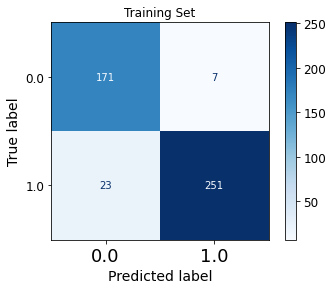

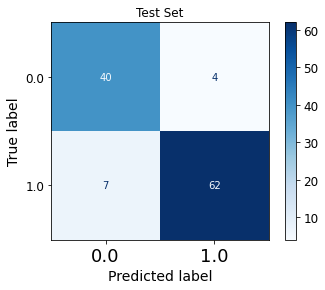

In [12]:
from HW2_Functions import predict_and_report

LR_Train_Scores=predict_and_report(set='Training Set',estimator=best_log_reg,X=X_train,y=Y_train)
LR_Test_Scores=predict_and_report(set='Test Set',estimator=best_log_reg,X=X_test,y=y_test)

**b) Linear SVM**

In [13]:
from sklearn.svm import SVC

def LSVM(X_train, Y_train):
    svc = SVC(probability=True)
    C = np.array([0.01, 1, 10, 100, 1000])
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
    svm_lin = GridSearchCV(estimator=pipe, param_grid={'svm__kernel':['linear'], 'svm__C':C}, scoring=['accuracy','f1','precision','recall','roc_auc'],
                 cv=skf, refit='roc_auc', verbose=1, return_train_score=True)
    svm_lin.fit(X_train, Y_train)
    return svm_lin.best_estimator_, svm_lin.best_params_

best_lin_svm,best_lin_svm_params=LSVM(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   54.0s finished


The best capacity $C$ is:

In [14]:
best_lin_svm_params['svm__C']

0.01

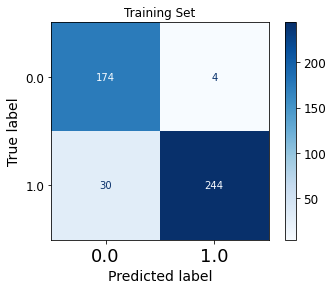

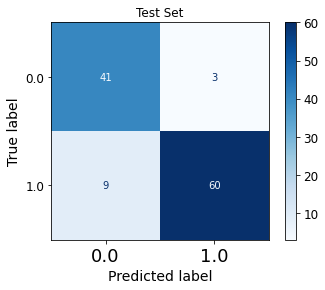

In [15]:
LSVM_Train_Scores=predict_and_report(set='Training Set',estimator=best_lin_svm,X=X_train,y=Y_train)
LSVM_Test_Scores=predict_and_report(set='Test Set',estimator=best_lin_svm,X=X_test,y=y_test)

Comments: confusion matrices of LR and linear SVM are quite similar, but linear SVM is computationaly expensive. 

#### 5.2) Non-linear Models

**a) Non-linear SVM**

In [16]:
def NLSVM(X_train, Y_train):
    nlsvc = SVC(probability=True)
    C = np.array([0.1,1, 10, 100])
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', nlsvc)])
    svm_nonlin = GridSearchCV(estimator=pipe,param_grid={'svm__kernel':['rbf','poly'], 'svm__C':C, 'svm__degree':[3,4],'svm__gamma':['auto','scale']},
                 scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
    svm_nonlin.fit(X_train, Y_train)
    return svm_nonlin.best_estimator_,svm_nonlin.best_params_

best_nlin_svm,best_nlin_svm_params= NLSVM(X_train, Y_train)

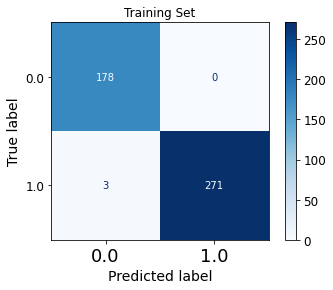

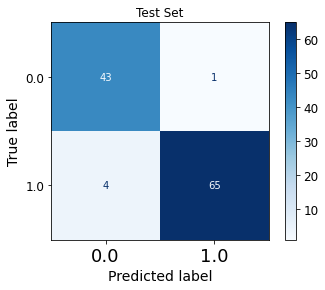

In [17]:
NLSVM_Train_Scores=predict_and_report(set='Training Set',estimator=best_nlin_svm,X=X_train,y=Y_train)
NLSVM_Test_Scores=predict_and_report(set='Test Set',estimator=best_nlin_svm,X=X_test,y=y_test)

**b) RFC**

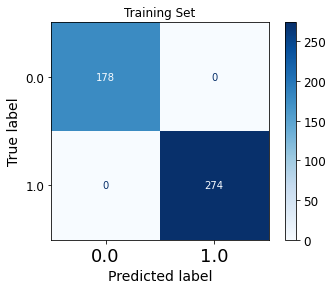

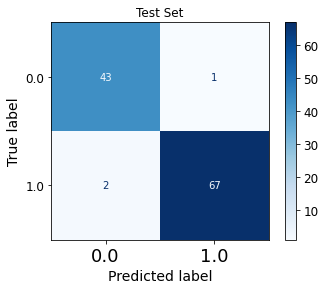

In [18]:
from sklearn.ensemble import RandomForestClassifier

def RFC(X_train, Y_train):
    rfc=RandomForestClassifier(random_state=42)
    param_grid = {'RF__max_features': ['auto', 'sqrt', 'log2'],'RF__criterion': ['gini', 'entropy'],'RF__class_weight': ['balanced', 'balanced_subsample']}
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('RF', rfc)])
    sh = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
                  cv=skf, refit='roc_auc', verbose=0, return_train_score=True)                                     
    sh.fit(X_train, Y_train)
    return sh.best_estimator_

RF=RFC(X_train, Y_train)

RFC_Train_Scores=predict_and_report(set='Training Set',estimator=RF,X=X_train,y=Y_train)
RFC_Test_Scores=predict_and_report(set='Test Set',estimator=RF,X=X_test,y=y_test)

#### 5.3) Performance Comparison of the 4 Classifiers

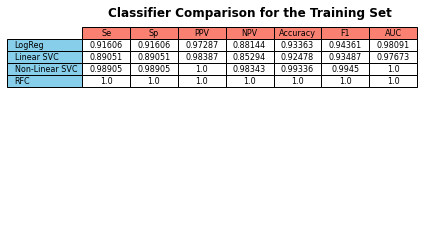

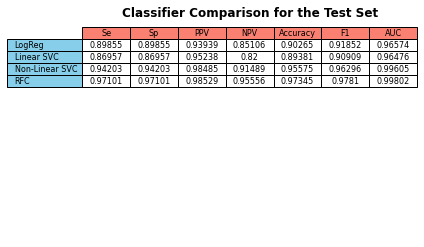

In [19]:
from HW2_Functions import Model_Comparison_Table

Scores_Train = np.array([LR_Train_Scores,LSVM_Train_Scores,NLSVM_Train_Scores,RFC_Train_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Train, Title='Classifier Comparison for the Training Set')

Scores_Test = np.array([LR_Test_Scores,LSVM_Test_Scores,NLSVM_Test_Scores,RFC_Test_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Test, Title='Classifier Comparison for the Test Set')

#### 5.4) Extra Classifiers

In addition with the previous 4 classifiers, we proposed to train 3 others:

-Linear Discriminant Analysis (linear)

-KNN (non-linear)

-Decision Tree (non-linear)

Below we report the confusion matrices for the test set. 

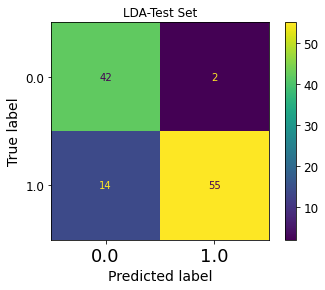

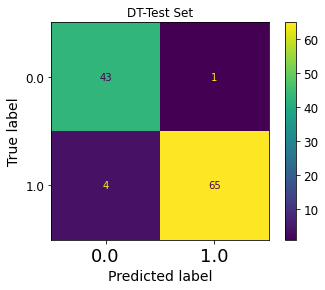

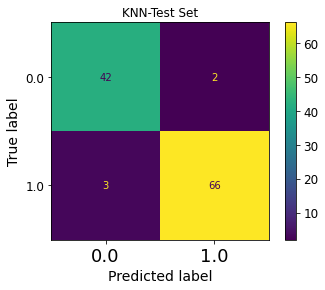

In [20]:
from HW2_extra_models import *

LDA, LDA_Scores = model_LDA(X_train, X_test, Y_train, y_test, flag=True)
DT, DT_Scores = model_DT(X_train, X_test, Y_train, y_test, flag=True)
KNN, KNN_Scores = model_KNN(X_train, X_test, Y_train, y_test, flag=True)

#### 5.5) Final Comparison with the 7 Classifiers

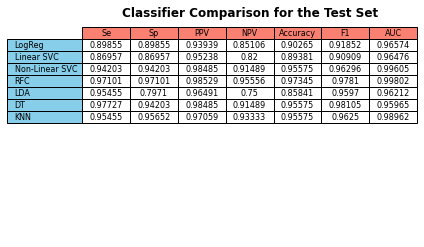

In [21]:
Scores_Test = np.array([LR_Test_Scores,LSVM_Test_Scores,NLSVM_Test_Scores,RFC_Test_Scores,LDA_Scores,DT_Scores,KNN_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Test, Title='Classifier Comparison for the Test Set',n_models=7)

We can clearly see that the Random Forest Classifier did the best job in terms of AUC, and generally performed better in almost all of the metrics than all of the other models. Both linear and non-linear models perform really well, but non-linear ones perform slightly better on this dataset. 

### 6) Feature Selection


**I.** We create a Random Forest Classifier, and use it to find the 2 most important features. Then, we plot a bar graph that shows the features sorted by importance (from left to right):


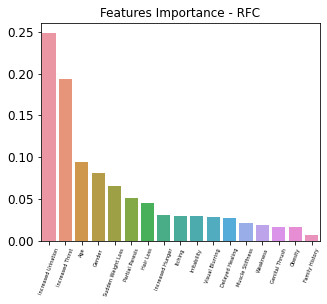

In [22]:
from HW2_Functions import RFC_Feature_Selection

scaler = StandardScaler()
x_tr = scaler.fit_transform(X_train)
x_tst = scaler.transform(X_test)


feat = pd.DataFrame(X.columns)[0]
RFC_feat_select = RandomForestClassifier(class_weight='balanced_subsample', max_features='log2')
RFC_feat_select.fit(x_tr, Y_train)
RFC_Feature_Selection(feat, RFC_feat_select)

**II.** Yes! We found in the data visualizing section that the features most correlated with the diagnosis were increased thirst and increased urination, and those findings are identical here.

### 7) Dimensionality Reduction

**a) 2D PCA** 

Here we perform dimensionality reduction using PCA, and then plot our data in a 2D plot:

In [23]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2,whiten=True)
x_tr_pca=pca.fit_transform(x_tr)
x_tst_pca=pca.transform(x_tst)

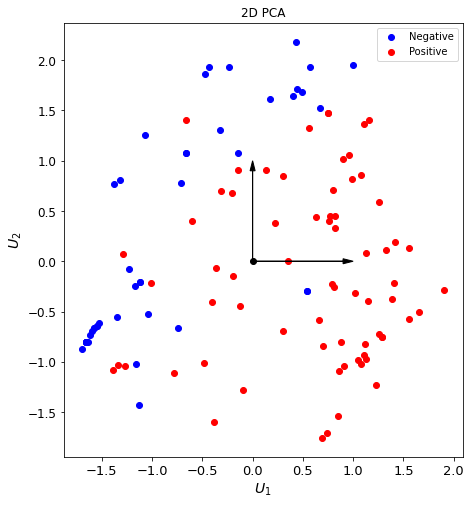

In [24]:
from HW2_Functions import plot_2d_pca
plot_2d_pca(x_tst_pca,y_test)

**b)** It's not entirely separable by a single line, but there is a clear difference in the centroids of the two clusters.

**c)** Now, we train the 4 first models (LR, linear SVM, non-linear SVM, RFC) on the dimensionality reduced training set, and then plot the model comparison table:

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.8s finished


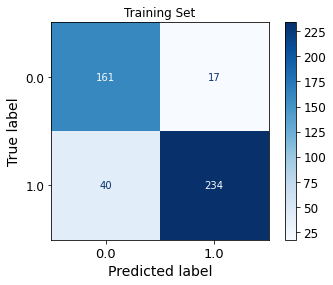

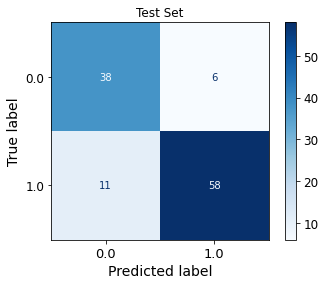

In [25]:

#------------Logistic Regression-----------------

best_log_reg_pca=LR(x_tr_pca,Y_train)

LR_pca_Train_Scores=predict_and_report(set='Training Set',estimator=best_log_reg_pca,X=x_tr_pca,y=Y_train)
LR_pca_Test_Scores=predict_and_report(set='Test Set',estimator=best_log_reg_pca,X=x_tst_pca,y=y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.3s finished


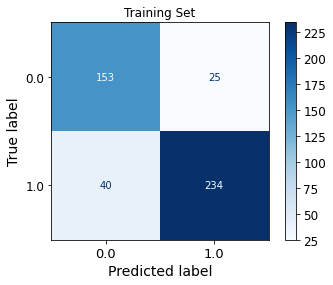

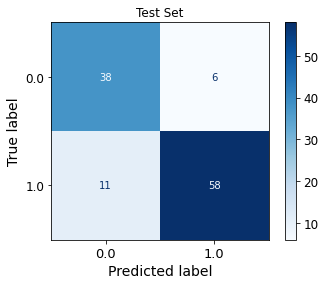

In [26]:
#--------Linear SVM---------------

best_lin_svm_pca,best_params_lin_svm_pca=LSVM(x_tr_pca,Y_train)

LSVM_pca_Train_Scores=predict_and_report(set='Training Set',estimator=best_lin_svm_pca,X=x_tr_pca,y=Y_train)
LSVM_pca_Test_Scores=predict_and_report(set='Test Set',estimator=best_lin_svm_pca,X=x_tst_pca,y=y_test)

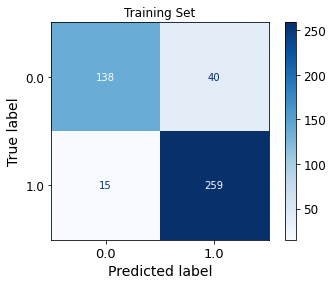

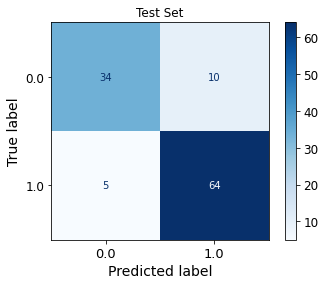

In [27]:
#----------Non Linear SVM---------------

best_nlin_svm_pca,best_params_nlin_svm_pca=NLSVM(x_tr_pca,Y_train)

NLSVM_pca_Train_Scores=predict_and_report(set='Training Set',estimator=best_nlin_svm_pca,X=x_tr_pca,y=Y_train)
NLSVM_pca_Test_Scores=predict_and_report(set='Test Set',estimator=best_nlin_svm_pca,X=x_tst_pca,y=y_test)

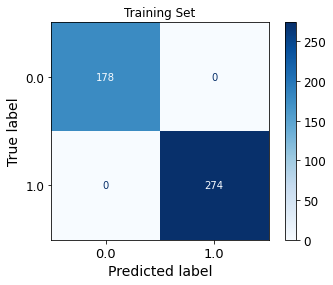

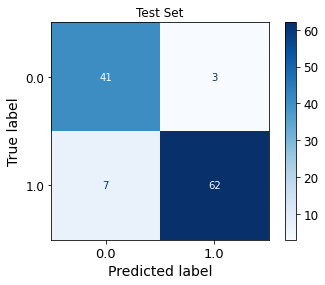

In [28]:
#------------------RFC-------------------

RF_pca = RFC(x_tr_pca,Y_train)

RFC_pca_Train_Scores=predict_and_report(set='Training Set',estimator=RF_pca,X=x_tr_pca,y=Y_train)
RFC_pca_Test_Scores=predict_and_report(set='Test Set',estimator=RF_pca,X=x_tst_pca,y=y_test)

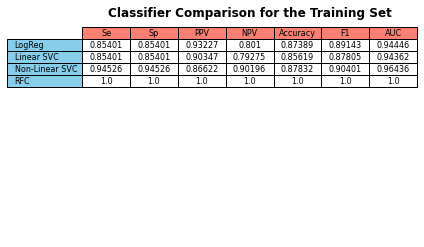

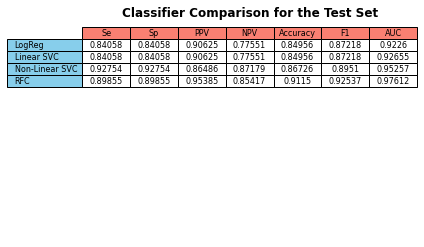

In [29]:
Scores_Train_pca = np.array([LR_pca_Train_Scores,LSVM_pca_Train_Scores,NLSVM_pca_Train_Scores,RFC_pca_Train_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Train_pca, Title='Classifier Comparison for the Training Set')

Scores_Test_pca = np.array([LR_pca_Test_Scores,LSVM_pca_Test_Scores,NLSVM_pca_Test_Scores,RFC_pca_Test_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Test_pca, Title='Classifier Comparison for the Test Set')

**d.** Now we train all of the models on the training set with only the 2 most important features found in section 6 (increased thirst and increased urination), and then plot the model comparison table:

In [30]:
X_train_2 = pd.concat([X_train['Increased Thirst'], X_train['Increased Urination']], axis=1)
X_test_2 = pd.concat([X_test['Increased Thirst'], X_test['Increased Urination']], axis=1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.3s finished


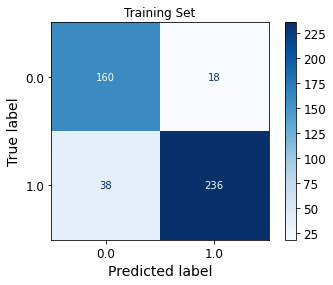

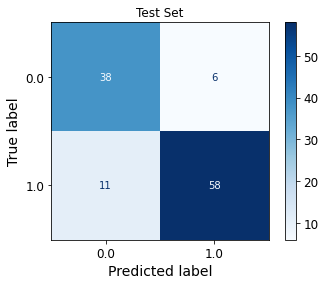

In [36]:
best_lr_2=LR(X_train_2,Y_train)

LR_2_Train_Scores=predict_and_report(set='Training Set',estimator=best_lr_2,X=X_train_2,y=Y_train)
LR_2_Test_Scores=predict_and_report(set='Test Set',estimator=best_lr_2,X=X_test_2,y=y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished


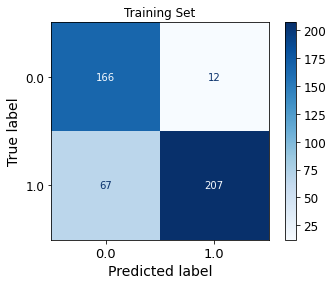

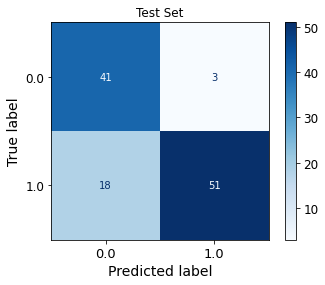

In [31]:
best_lsvm_2,best_lsvm_2_params=LSVM(X_train_2,Y_train)

LSVM_2_Train_Scores=predict_and_report(set='Training Set',estimator=best_lsvm_2,X=X_train_2,y=Y_train)
LSVM_2_Test_Scores=predict_and_report(set='Test Set',estimator=best_lsvm_2,X=X_test_2,y=y_test)

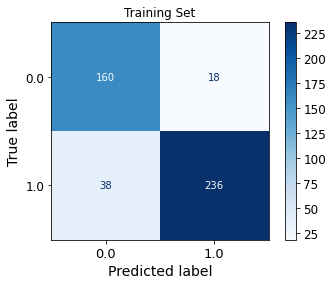

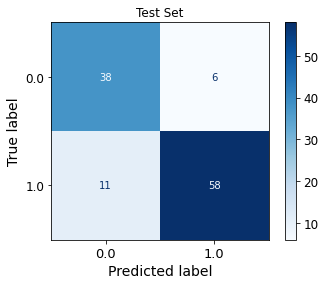

In [32]:
best_nlsvm_2,best_nlsvm_2_params=NLSVM(X_train_2,Y_train)

NLSVM_2_Train_Scores=predict_and_report(set='Training Set',estimator=best_nlsvm_2,X=X_train_2,y=Y_train)
NLSVM_2_Test_Scores=predict_and_report(set='Test Set',estimator=best_nlsvm_2,X=X_test_2,y=y_test)

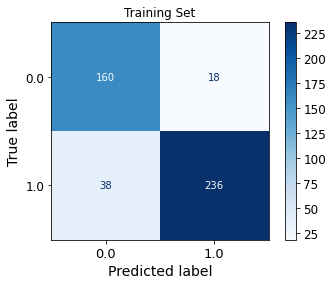

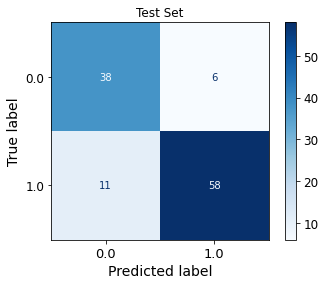

In [33]:
RF_2 = RFC(X_train_2,Y_train)

RFC_2_Train_Scores=predict_and_report(set='Training Set',estimator=RF_2,X=X_train_2,y=Y_train)
RFC_2_Test_Scores=predict_and_report(set='Test Set',estimator=RF_2,X=X_test_2,y=y_test)

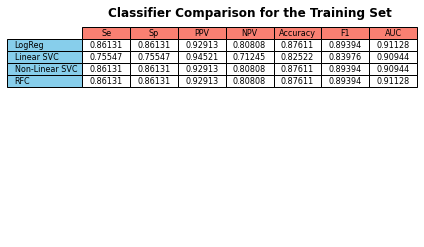

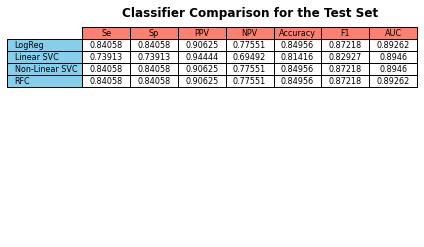

In [37]:
Scores_Train_2 = np.array([LR_2_Train_Scores,LSVM_2_Train_Scores,NLSVM_2_Train_Scores,RFC_2_Train_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Train_2, Title='Classifier Comparison for the Training Set')

Scores_Test_2 = np.array([LR_2_Test_Scores,LSVM_2_Test_Scores,NLSVM_2_Test_Scores,RFC_2_Test_Scores]).round(decimals=5)
Model_Comparison_Table(Table_Data=Scores_Test_2, Title='Classifier Comparison for the Test Set')

**e.** It's easy to see that the dimensionality reduced training set works better, but it's still pretty astounding that the 2-feature model did pretty good considering we removed 15 out of 17 total features from the training set. Obviously there is the question of computation time, but for the size of this dataset, both the dimensionality reduced and the 2-feature training sets were fitted in approximately the same time, so in this case we would choose the dimensionality reduced training set.